In [ ]:
!pip install transformers
import torch
import pandas as pd
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification

     |████████████████████████████████| 3.1 MB 4.0 MB/s 
     |████████████████████████████████| 596 kB 78.3 MB/s 
     |████████████████████████████████| 3.3 MB 19.3 MB/s 
     |████████████████████████████████| 61 kB 633 kB/s 
     |████████████████████████████████| 895 kB 77.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
df = pd.read_csv('labelled_data_bert2.csv').astype(str)
df['Class'].value_counts()
possible_labels = df.Class.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
df['label'] = df.Class.replace(label_dict)
df.head()

,text,Class,label
0,oh sure everything ive heard carrying child te...,1,0
1,guide get abortion pills plan,1,0
2,wtf abbott male republicans mine every womans ...,1,0
3,woman getting abortion effect quality life non...,1,0
4,doesnt want rape victim abortion kill half sta...,1,0


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=0.15, 
                                                  random_state=42, 
                                                  stratify=df.label.values)

In [ ]:

df['data_type'] = ['not_set']*df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'
df.groupby(['Class', 'label', 'data_type']).count()


text
Class label data_type      
0     1     train       204
            val          37
1     0     train       233
            val          41

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)
encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].label.values)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [ ]:
len(dataset_train), len(dataset_val)


(437, 78)

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 2

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)
epochs = 20

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

In [ ]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [ ]:
import random
import numpy as np
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda


In [ ]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [ ]:
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    #torch.save(model.state_dict(), 'finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/219 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.7036266069025754
Validation loss: 0.5948652311777457
F1 Score (Weighted): 0.6648947951273533


Epoch 2:   0%|          | 0/219 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.6258208921953151
Validation loss: 0.5805330721613688
F1 Score (Weighted): 0.6796452492655025


Epoch 3:   0%|          | 0/219 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.5085387165428534
Validation loss: 1.3241630611965098
F1 Score (Weighted): 0.6137039431157078


Epoch 4:   0%|          | 0/219 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.2613147847895557
Validation loss: 1.4308082088380336
F1 Score (Weighted): 0.7287510091108291


Epoch 5:   0%|          | 0/219 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.18977128734177437
Validation loss: 1.661092148978078
F1 Score (Weighted): 0.729832387993117


Epoch 6:   0%|          | 0/219 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.11284943620371844
Validation loss: 1.734544352241732
F1 Score (Weighted): 0.6873348873348875


Epoch 7:   0%|          | 0/219 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.06272481283059739
Validation loss: 1.9251292182195288
F1 Score (Weighted): 0.7013205364706286


Epoch 8:   0%|          | 0/219 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.03419598672342578
Validation loss: 2.0525861642467462
F1 Score (Weighted): 0.7305470565084363


Epoch 9:   0%|          | 0/219 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.029384584719148787
Validation loss: 2.2024138783278593
F1 Score (Weighted): 0.717948717948718


Epoch 10:   0%|          | 0/219 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.0182254014687374
Validation loss: 2.36767731372917
F1 Score (Weighted): 0.6916971916971917


Epoch 11:   0%|          | 0/219 [00:00<?, ?it/s]


Epoch 11
Training loss: 0.013328252508202418
Validation loss: 2.242644315377383
F1 Score (Weighted): 0.7287510091108291


Epoch 12:   0%|          | 0/219 [00:00<?, ?it/s]


Epoch 12
Training loss: 0.01493217560791434
Validation loss: 2.482120404141591
F1 Score (Weighted): 0.6916971916971917


Epoch 13:   0%|          | 0/219 [00:00<?, ?it/s]


Epoch 13
Training loss: 0.048080312734429635
Validation loss: 2.397016906014286
F1 Score (Weighted): 0.7287510091108291


Epoch 14:   0%|          | 0/219 [00:00<?, ?it/s]


Epoch 14
Training loss: 0.020533256140842154
Validation loss: 2.6730606945040143
F1 Score (Weighted): 0.6904438679731358


Epoch 15:   0%|          | 0/219 [00:00<?, ?it/s]


Epoch 15
Training loss: 0.033355636432952036
Validation loss: 2.604307915917161
F1 Score (Weighted): 0.6916971916971917


Epoch 16:   0%|          | 0/219 [00:00<?, ?it/s]


Epoch 16
Training loss: 0.013065730288913675
Validation loss: 2.580928796177408
F1 Score (Weighted): 0.7041021392305568


Epoch 17:   0%|          | 0/219 [00:00<?, ?it/s]


Epoch 17
Training loss: 0.015355486344701831
Validation loss: 2.6050726707490424
F1 Score (Weighted): 0.7164494420308374


Epoch 18:   0%|          | 0/219 [00:00<?, ?it/s]


Epoch 18
Training loss: 0.01400638892523374
Validation loss: 2.6004381608058442
F1 Score (Weighted): 0.7164494420308374


Epoch 19:   0%|          | 0/219 [00:00<?, ?it/s]


Epoch 19
Training loss: 0.013801865662891577
Validation loss: 2.624958916108228
F1 Score (Weighted): 0.7029177718832892


Epoch 20:   0%|          | 0/219 [00:00<?, ?it/s]


Epoch 20
Training loss: 0.01069800785235908
Validation loss: 2.625419070084694
F1 Score (Weighted): 0.7029177718832892


In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)
_, predictions, true_vals = evaluate(dataloader_validation)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
accuracy_per_class(predictions, true_vals)

Class: 1
Accuracy: 41/41

Class: 0
Accuracy: 1/37



In [ ]:
from deepface import DeepFace

Directory  /root /.deepface created
Directory  /root /.deepface/weights created


In [ ]:
import zipfile
with zipfile.ZipFile('profile_images (2) (1).zip', 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
import os
user_data = pd.read_csv('ConcatenatedUsers_m3.csv')

In [ ]:
race_collection = {}
counter = 0
total = user_data.shape[0]
for _, row in user_data.iterrows():
  counter+=1

  if counter%1000==0:
    print(f"Progress = {counter*100/total}%")

  img = f'/content/profile_images/user_{row["id"]}.jpg'
  if os.path.isfile(img):
    race_collection[row['id']] = DeepFace.analyze(img_path = img, actions = ['race'], enforce_detection=False)['dominant_race']


Progress = 3.963535473642489%
Progress = 7.927070947284978%
Progress = 11.890606420927467%
Progress = 15.854141894569956%
Progress = 19.817677368212447%
Progress = 23.781212841854934%
Progress = 27.744748315497425%
Progress = 31.708283789139912%
Progress = 35.6718192627824%
Progress = 39.635354736424894%
Progress = 43.59889021006738%
Progress = 47.56242568370987%
Progress = 51.525961157352356%
Progress = 55.48949663099485%
Progress = 59.45303210463734%
Progress = 63.416567578279825%
Progress = 67.38010305192232%
Progress = 71.3436385255648%
Progress = 75.3071739992073%
Progress = 79.27070947284979%
Progress = 83.23424494649227%
Progress = 87.19778042013476%
Progress = 91.16131589377724%
Progress = 95.12485136741974%
Progress = 99.08838684106223%


In [ ]:
race_collection
with open('readme.txt', 'w') as f:
    for line in str(race_collection):
        f.write(line)

In [ ]:
race_collection

{2822594617: 'white',
 153642560: 'white',
 3449791700: 'white',
 4012849515: 'white',
 1134538801680977920: 'white',
 1374732358142763019: 'white',
 1128823229831770112: 'white',
 16306183: 'white',
 4499430739: 'black',
 287834923: 'middle eastern',
 1921432573: 'white',
 116630205: 'white',
 1381345898324721670: 'asian',
 113049386: 'white',
 23719539: 'white',
 4075241: 'white',
 32283017: 'asian',
 15616605: 'middle eastern',
 1303728994320293890: 'white',
 990649052168585218: 'white',
 1395153448585269252: 'black',
 2429423276: 'middle eastern',
 1044383950490218496: 'white',
 1288613164913958917: 'white',
 1095471475329384448: 'white',
 364277321: 'middle eastern',
 58859004: 'white',
 847960653369180161: 'white',
 1299866345874497536: 'middle eastern',
 278341592: 'white',
 12469012: 'white',
 305312450: 'white',
 179703839: 'white',
 1116390036763811840: 'middle eastern',
 1114375205353394176: 'asian',
 632392229: 'white',
 217870611: 'white',
 1138927550737068033: 'white',
 9

In [ ]:
df.head()

,id,text,Class
0,143285554718797,oh sure everything ive heard carrying child te...,1.0
1,143285549887383,guide get abortion pills plan,1.0
2,143285548112773,wtf abbott male republicans mine every womans ...,1.0
3,143285547593514,left states like abortion gay rights,2.0
4,143285541766372,im glad see folks using platforms talk texas a...,2.0


In [ ]:
df1=pd.read_csv('ConcatenatedUsers_m3.csv')


In [ ]:
df2=df1.drop(['created_at','profile_image_url','url','entities','pinned_tweet_id'],axis=1)

In [ ]:
df2.head()

,description,name,protected,verified,username,id,location,gender,age,org
0,"(he/they) For those who need, we must do what ...",MintyFreshness,False,False,Intensefreshnes,2822594617,The cum zone,male,>=40,non-org
1,"📍 Dallas, TX I show you where the adventure is...",Dallas Latina Foodie,False,False,allycelebrates,153642560,"Dallas, TX",female,19-29,non-org
2,#FBR #FuckTrump #TaxTheRich #BlackLivesMatter ...,DMoney,False,False,dmoney31267,3449791700,"Colorado, USA",male,>=40,non-org
3,Stock Investor / Anytime Fitness Member,Ray Blackwell,False,False,RayBlackwell7,4012849515,"Warren, PA",male,>=40,non-org
4,press secretary for all gay people. digital gr...,kaitlyn 🇬🇹,False,False,kaitlynsolares,1134538801680977920,Boston 🐀,female,19-29,non-org


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [ ]:
df.head()

,id,text,Class
0,143285554718797,oh sure everything ive heard carrying child te...,1.0
1,143285549887383,guide get abortion pills plan,1.0
2,143285548112773,wtf abbott male republicans mine every womans ...,1.0
3,143285547593514,left states like abortion gay rights,2.0
4,143285541766372,im glad see folks using platforms talk texas a...,2.0


In [ ]:
text = " ".join(cat.split()[0] for cat in df.text)

In [ ]:
text

'oh guide wtf left im baby woman actually hundred health end fond abortion federalist mouth doesnt court george still starting hooray even last onto blessing good im learning everyone united guess ok sure abortion calls cant abortion babies clogging feel trying instagram week thats sometimes learn patient yo new stand babies must abortion good safe top standing abortion dont guy restrictive fuuuuh wants pandemic look alarming ok love prolifers another prolifers dems law probam abortion please position abortion nope sent family erin antiabortion supercharge never dont nope stopthesteal reminder abortion restrictive telemedicine animationabortion terrify aint educating wont agree buy offering abortion doesnt hours would anyone isnt th youre christians bad abortion ive want pretty let texas current much fight roasted scotus support outlawing yet new college much great youre religious shes great point abortion fuck absolutely catholic support know tx antiimmigration thanks know feminists i

In [ ]:
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)


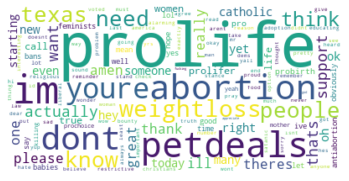

In [ ]:
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()